In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gym
from gym import spaces

class TradingEnv(gym.Env):
    def __init__(self, prices):
        super(TradingEnv, self).__init__()
        self.prices = prices.reset_index(drop=True)  # Reset index to ensure consistent integer indexing
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        self.current_step = 0

    def step(self, action):
        done = self.current_step >= len(self.prices) - 1
        current_price = self.prices.iloc[self.current_step]
        reward = 0
        transaction_cost = 0.01  # Example transaction cost percentage
    
        if not done:
            if action == 1:  # Buy
                reward = (self.prices.iloc[self.current_step + 1] - current_price) - (current_price * transaction_cost)
            elif action == 2:  # Sell
                reward = (current_price - self.prices.iloc[self.current_step + 1]) - (current_price * transaction_cost)
    
        self.current_step += 1
        next_state = self.current_step if not done else self.current_step - 1
        return next_state, reward, done, {}

    def reset(self):
        self.current_step = 0
        return self.current_step


# Initialize the environment with historical data
training_data = yf.download("AAPL", start="2019-01-01", end="2023-01-01")['Adj Close']
env = TradingEnv(training_data)  # Create an instance of the TradingEnv with the training data

# Q-Learning parameters
alpha = 0.1
gamma = 0.99
epsilon = 0.1

# Q-Table
q_table = np.zeros((len(training_data), env.action_space.n))

# Training loop
for episode in range(1000):
    state = env.reset()
    done = False

    while not done:
        if np.random.random() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit

        next_state, reward, done, info = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state]) if not done else 0  # If done, consider next_max to be 0

        # Update the Q-value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value
        state = next_state

[*********************100%%**********************]  1 of 1 completed


In [14]:
# Testing the model
test_data = yf.download("AAPL", start="2023-01-01", end="2024-01-01")['Adj Close']
test_env = TradingEnv(test_data)
state = test_env.reset()

done = False
total_profit = 0
actions_taken = []  # List to store actions taken by the model

while not done:
    action = np.argmax(q_table[state])  # Use the learned Q-table to decide the best action
    next_state, reward, done, _ = test_env.step(action)
    total_profit += reward
    actions_taken.append(action)
    state = next_state

# Calculate total profit and compare with buy-and-hold strategy
buy_and_hold_profit = test_data.iloc[-1] - test_data.iloc[0]
print(f"Total Profit from RL Model: {total_profit}")
print(f"Buy and Hold Profit: {buy_and_hold_profit}")

[*********************100%%**********************]  1 of 1 completed

Total Profit from RL Model: -122.16480613708497
Buy and Hold Profit: 68.0683364868164


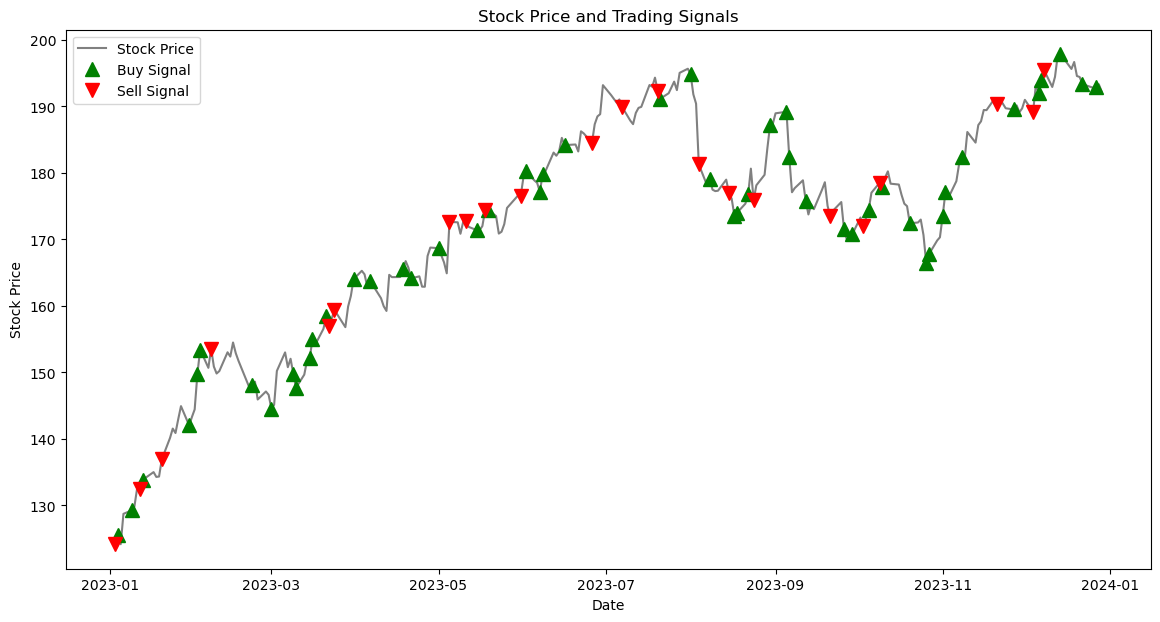

In [15]:
# Plotting the actions and prices
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data.values, label='Stock Price', color='gray')

buy_signals = [i for i, action in enumerate(actions_taken) if action == 1]
sell_signals = [i for i, action in enumerate(actions_taken) if action == 2]

plt.plot(test_data.index[buy_signals], test_data.values[buy_signals], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(test_data.index[sell_signals], test_data.values[sell_signals], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('Stock Price and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()